# Εργασία 1

## Α. Αναγνώριση μονών και ζυγών αριθμών στα δεκαδικά ψηφία της MNIST

### 1. Προετοιμασία των δεδομένων

Σκοπός της εργασίας είναι η αξιολόγηση μοντέλων τα οποία κατηγοριοποιούν εικόνες από χειρόγραφα ψηφία σε μονούς και ζυγούς αριθμούς.

Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

Παρακάτω βλέπουμε τις εκδόσεις της python και των βιβλιοθηκών που χρησιμοποιήθηκαν στην εργασία.

In [66]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import cvxopt
import sys

print('Python version:', sys.version)
print('scikit-learn version:', sklearn.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', matplotlib.__version__)
print('pandas version', pd.__version__)
print('cvxopt version', cvxopt.__version__)

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
scikit-learn version: 0.23.2
numpy version: 1.18.5
matplotlib version: 3.3.2
pandas version 1.1.3
cvxopt version 1.2.0


Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [67]:
import scipy.io
import urllib.request
import os

np.random.seed(0)

url = 'https://cs.nyu.edu/~roweis/data/mnist_all.mat'
filename = 'mnist_all.mat'

if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')

mat = scipy.io.loadmat(filename)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

Οι εικόνες των ψηφίων έχουν μέγεθος 784 = 28x28.

Σκοπός της εργασίας είναι η αξιολόγηση μοντέλων τα οποία κατηγοριοποιούν εικόνες από χειρόγραφα ψηφία σε μονούς και ζυγούς αριθμούς. Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [68]:
digit = mat['train2'][0]
digit.shape

(784,)

Παρακάτω φαίνονται οι εικόνες πέντε ψηφίων.

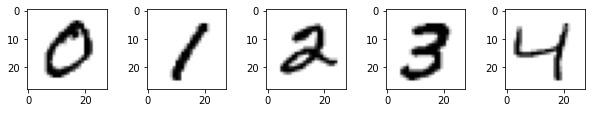

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 5
fig, axs = plt.subplots(1, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
for i in range(n):
    digit = mat['train' + str(i)][0]
    digit = digit.reshape((28, 28))
    axs[i].imshow(digit, cmap=plt.cm.binary)
plt.show()

Οι είκονες και οι ετικέτες φορτώνονται σε numpy arrays. Το μέγεθος του train set είναι 60000 και του test set 10000. Η κανονικοποίηση στο διάστημα [0, 1] γίνεται με διαίρεση με το 255 το οποίο είναι η μέγιστη τιμή της φωτεινότητας ενός pixel.

In [70]:
x_train, y_train, x_test, y_test = [], [], [], []

for key, data in mat.items():
    if 'train' in key:
        for x in data:
            x_train.append(x)
            num = int(key[-1])
            y_train.append(num)
    if 'test' in key:
        for x in data:
            x_test.append(x)
            num = int(key[-1])
            y_test.append(num)

x_train = np.array(x_train, dtype=np.double)
y_train = np.array(y_train, dtype=np.double)
x_test = np.array(x_test, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
x_test_original = x_test

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (60000, 784)
y_train.shape = (60000,)
x_test.shape = (10000, 784)
y_test.shape = (10000,)


In [71]:
x_train = x_train/255.
x_test = x_test/255.

print()
print('x_train is in [{}, {}]'.format(np.min(x_train), np.max(x_train)))
print('x_test is in [{}, {}]'.format(np.min(x_test), np.max(x_test)))


x_train is in [0.0, 1.0]
x_test is in [0.0, 1.0]


Το παρακάτω ιστόγραμμα μας δείχνει ότι οι κλάσεις των ψηφίων είναι ζυγισμένες. 

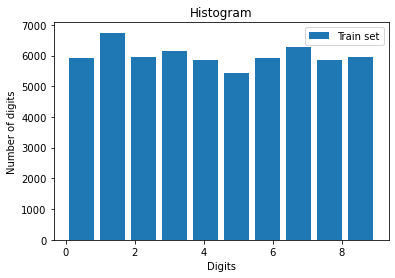

In [72]:
plt.hist(y_train, label='Train set', rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Λόγω του μεγάλου μεγέθους των δεδομένων, ως μέθοδος αξιολόγησης των μοντέλων, για την επιλογή των παραμέτρων τους, επιλέγεται η διαστρωματωμένη παρακράτηση (stratified holdout). Χρησιμοποιώντας αυτή τη μέθοδο χωρίζεται το train set ξανά σε train set και validation set διασφαλίζοντας ότι η κατανομή των κλάσεων παραμένει η ίδια και στα δύο set. Έτσι όλα τα ψηφία αντιπροσωπεύονται ισάξια.

In [73]:
from sklearn import model_selection

x_train_all = x_train
y_train_all = y_train

split = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, val_index in split.split(x_train_all, y_train_all):
    x_train, y_train = x_train_all[train_index], y_train_all[train_index]
    x_val, y_val = x_train_all[val_index], y_train_all[val_index]

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)

x_train.shape = (36000, 784)
y_train.shape = (36000,)
x_val.shape = (24000, 784)
y_val.shape = (24000,)


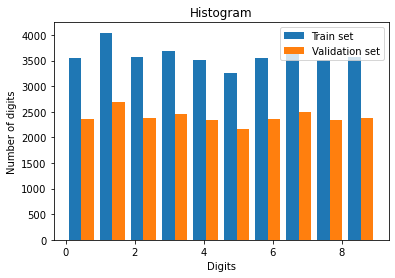

In [74]:
plt.hist((y_train, y_val), label=('Train set', 'Validation set'), rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Αλλάζουμε τις ετικέτες σε -1 και 1 έτσι ώστε να αντιπροσωπεύουν τους ζυγούς και τους μονούς αριθμούς αντίστοιχα.

In [75]:
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

y_train[y_train == 0] = -1.0
y_val[y_val == 0] = -1.0
y_test[y_test == 0] = -1.0

### 2. Μείωση διαστάσεων

Γίνεται μείωση των διαστάσεων με την τεχνική PCA διατηρώντας το 90% της διασποράς. Η διάσταση των δεδομένων μειώνεται από 784 σε 87.

In [76]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.9, svd_solver='full', random_state=0)
x_train = pca.fit_transform(x_train)
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)

x_train_all = np.concatenate((x_train, x_val))
y_train_all = np.concatenate((y_train, y_val))

print('x_train_all.shape =', x_train_all.shape)
print('x_train.shape =', x_train.shape)
print('x_val.shape =', x_val.shape)
print('x_test.shape =', x_test.shape)

x_train_all.shape = (60000, 87)
x_train.shape = (36000, 87)
x_val.shape = (24000, 87)
x_test.shape = (10000, 87)


Δημιουργείται ένα μικρό train set το οποίο χρησιμοποιείται για εκπαίδευση στο MySVM που είναι δικής μου υλοποίησης επειδή χρησιμοποιεί πίνακες που απαιτούν πολλή μνήμη. Επίσης χρησιμοποιείται και από το sklearn για σύγκριση.

In [129]:
x_train_all_small = x_train_all[:8000] # FIXME
y_train_all_small = y_train_all[:8000]
x_train_small = x_train[:4800]
y_train_small = y_train[:4800]
x_val_small = x_val[:3200]
y_val_small = y_val[:3200]

Οι κλάσεις δεν φαίνονται διαχωρίσιμες στο επίπεδο των δυο πρώτων ιδιοδιανυσμάτων.

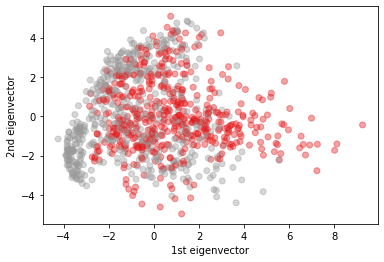

In [78]:
plt.scatter(x_train[:1000, 0], x_train[:1000, 1], c=y_train[:1000], cmap='Set1', alpha=0.4)
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')
plt.show()

### 3.  Αξιολόγηση μοντέλων

#### 3.1 Περιγραφή της διαδικασίας

Η συνάρτηση grid_search αξιολογεί το κάθε μοντέλο στο validation set για διάφορες τιμές των παραμέτρων. Ως μετρική αξιολόγησης επιλέγεται το accuracy επείδη οι κλάσεις είναι ζυγισμένες και οι λάθος αποφάσεις για μονό ή ζυγό αριθμό θεωρούνται εξίσου σημαντικές. Έπειτα η plot_grid_search δημιουργεί διαγράμματα για το accuracy και τον χρόνο εκπαίδευσης. Τέλος η συνάρτηση evaluate_model εκπαιδεύει το βέλτιστο μοντέλο εκ νέου σε ολόκληρο το train set και το αξιολογεί στο test set και δίνει κάποια παραδείγματα σωστής και λάθους κατηγοριοποίησης.

In [115]:
from sklearn import metrics
from time import time

def grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=0):
    param_grid = model_selection.ParameterGrid(param_dict)
    all_params = list(param_grid)
    num = len(all_params)
    train_acc = np.zeros(num)
    val_acc = np.zeros(num)
    t = np.zeros(num)
    
    for i, params in enumerate(param_grid):
        model.set_params(**params)
        t1 = time()
        model.fit(x_train, y_train)
        t2 = time()
        t[i] = t2 - t1
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        train_acc[i] = metrics.accuracy_score(y_train, y_train_pred)
        val_acc[i] = metrics.accuracy_score(y_val, y_val_pred)
        if verbose >= 2:
            print('[{}/{}] {}: train_acc = {:.4f}, val_acc = {:.4f} | t = {:.2f} sec = {:.1f} min'
             .format(i+1, num, params, train_acc[i], val_acc[i], t[i], t[i]/60))
    
    best_i = np.argmax(val_acc)
    best_params = all_params[best_i]
    if verbose >= 1:
        print()
        print('Best params =', best_params)
        print('Maximum validation accuracy =', val_acc[best_i])
        print()
    
    results = {
        'params' : all_params,
        'train_score': train_acc,
        'val_score': val_acc,
        'time': t,
        'best_index': best_i,
        'best_params': best_params
    }
    
    return results

In [80]:
from collections import defaultdict

def plot_grid_search(results, param1, param2=None, xscale='linear'):
    all_params = results['params']
    train_acc = results['train_score']
    val_acc = results['val_score']
    t = results['time']
    train_acc_dict = defaultdict(lambda: [])
    val_acc_dict = defaultdict(lambda: [])
    t_dict = defaultdict(lambda: [])
    values1_dict = defaultdict(lambda: [])
    
    for i, params in enumerate(all_params):
        if param2 in params:
            val2 = params[param2]
        else:
            val2 = None
        train_acc_dict[val2].append(train_acc[i])
        val_acc_dict[val2].append(val_acc[i])
        t_dict[val2].append(t[i])
        values1_dict[val2].append(params[param1])
    
    for val2, val_acc_vals in val_acc_dict.items():
        values1 = values1_dict[val2]
        train_acc_vals = train_acc_dict[val2]
        if val2 is None:
            train_label = 'Train'
            val_label = 'Validation'
        else:
            train_label = param2 + ' = ' + str(val2) + ' (Train)'
            val_label = param2 + ' = ' + str(val2) + ' (Validation)'
        plt.plot(values1, train_acc_vals, label=train_label, linestyle='dashed')
        plt.plot(values1, val_acc_vals, label=val_label)
        
    plt.title('Score')
    plt.ylabel('Accuracy')
    plt.xlabel(param1)
    plt.xscale(xscale)
    plt.legend()
    plt.show()
    
    for val2, t_vals in t_dict.items():
        values1 = values1_dict[val2]
        if val2 is not None:
            label = param2 + ' = ' + str(val2)
        else:
            label = None
        plt.plot(values1, t_vals, label=label)
        
    plt.title('Training time')
    plt.ylabel('Time (sec)')
    plt.xlabel(param1)
    plt.xscale(xscale)
    if param2 is not None:
        plt.legend()
    plt.show()

In [116]:
final_results = []

def evaluate_model(model_str, model, best_params, x_train, y_train, x_test, y_test):
    print('Training on the original train set with params =', best_params)
    model.set_params(**best_params)
    t1 = time()
    model.fit(x_train, y_train)
    t2 = time()
    print('Training time = {:.2f} sec = {:.1f} min'.format(t2 - t1, (t2 - t1)/60))
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    train_acc = metrics.accuracy_score(y_train, y_train_pred)
    test_acc = metrics.accuracy_score(y_test, y_test_pred)
    print('Train accuracy =', train_acc) 
    print('Test accuracy =', test_acc)
    
    n = 5
    correct_indices = np.where(y_test == y_test_pred)[0]
    incorrect_indices = np.where(y_test != y_test_pred)[0]
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)
    
    fig, axs = plt.subplots(1, n, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5)
    for j, i in enumerate(correct_indices[:n]):
        digit = x_test_original[i].reshape((28, 28))
        axs[j].imshow(digit, cmap=plt.cm.binary)
        axs[j].set_title('Correct')
    plt.show()
    
    fig, axs = plt.subplots(1, n, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5)
    for j, i in enumerate(incorrect_indices[:n]):
        digit = x_test_original[i].reshape((28, 28))
        axs[j].imshow(digit, cmap=plt.cm.binary)
        axs[j].set_title('Error')
    plt.show()
    
    best_params_str = ''
    for param, value in best_params.items():
        if best_params_str != '':
            best_params_str += ', '
        best_params_str += param
        best_params_str += ' = '
        if isinstance(value, float):
            best_params_str += '{:.4f}'.format(value)
        else:
            best_params_str += str(value)
    
    res = {
        'Classifier': model_str,
        'Parameters': best_params_str,
        'Train Accuracy': "{:.4f}".format(train_acc),
        'Test Accuracy': "{:.4f}".format(test_acc),
        'Training Time (sec)': int(t2 - t1)
    }
    
    final_results.append(res)

#### 3.2 Dummy Classifier

Ο Dummy Classifier χρησιμοποίεται ως ένα απλό baseline για τη σύγκριση με τα άλλα μοντέλα. Επιλέγει πάντα την πιο συχνή ετικέτα στο train set.

In [82]:
from sklearn import dummy

model = dummy.DummyClassifier(strategy='most_frequent', random_state=0)

t1 = time()
model.fit(x_train, y_train)
t2 = time()
t = t2 - t1
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_acc = metrics.accuracy_score(y_train, y_train_pred)
test_acc = metrics.accuracy_score(y_test, y_test_pred)

print('Training time = {} sec'.format(int(t)))
print('Train accuracy =', train_acc)
print('Test accuracy =', test_acc)

res = {
    'Classifier': 'Dummy Classifier',
    'Parameters': "strategy = 'most_frequent'",
    'Train Accuracy': "{:.4f}".format(train_acc),
    'Test Accuracy': "{:.4f}".format(test_acc),
    'Training Time (sec)': int(t)
}
final_results.append(res)

Training time = 0 sec
Train accuracy = 0.5084444444444445
Test accuracy = 0.5074


#### 3.3 My SVM

Ακολουθεί υλοποίηση ενός SVM classifier με linear kernel. Ο Quadratic Programming solver της βιβλιοθήκης CVXOPT υπολογίζει τους πολλαπλασιαστές Lagrange του δυϊκού προβλήματος του SVM.

In [83]:
from cvxopt import matrix, solvers

class MySVM(object):
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.sv_x = None
        self.sv_y = None
        self.alphas = None
        self.b = 0
    
    def set_params(self, **params):
        if not params:
            return self
        self.C = params.get('C', self.C)
        self.kernel = params.get('kernel', self.kernel)
        self.degree = params.get('degree', self.degree)
        self.gamma = params.get('gamma', self.gamma)
        self.coef0 = params.get('coef0', self.coef0)
        return self
    
    def _linear_kernel(self, X, Z):
        return np.matmul(X, Z.T)
    
    def _poly_kernel(self, X, Z):
        return np.power(self.gamma*np.matmul(X, Z.T) + self.coef0, self.degree)

    def _rbf_kernel(self, X, Z):
        n = X.shape[0]
        m = Z.shape[0]
        XX = np.dot(np.sum(np.power(X, 2), 1).reshape(n, 1), np.ones((1, m)))
        ZZ = np.dot(np.sum(np.power(Z, 2), 1).reshape(m, 1), np.ones((1, n)))     
        return np.exp(-self.gamma*(XX + ZZ.T - 2 * np.dot(X, Z.T)))
    
    def _kernel(self, X, Z):
        if self.kernel == 'linear':
            return self._linear_kernel(X, Z)
        elif self.kernel == 'poly':
            return self._poly_kernel(X, Z)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X, Z)
        else:
            raise Exception('Invalid kernel')
    
    def fit(self, X, y):
        # Convert the problem to a Quadratic Programming problem of the form:
        # minimize (1/2)(x.T)Px + (q.T)x
        # s.t Gx <= h, Ax = b
        
        m, n = X.shape
        
        if self.kernel in ('poly', 'rbf'):
            if self.gamma == 'scale':
                self.gamma = 1./(n*X.var())
            elif self.gamma == 'auto':
                self.gamma = 1./n
        
        K = self._kernel(X, X)
        y = y.reshape(-1, 1)
        P = matrix(np.matmul(y, y.T)*K)
        q = matrix(-np.ones((m, 1)))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), self.C*np.ones(m))))
        
        # Run Quadratic Programming Solver
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x'])
        
        # Get support vectors
        if self.kernel == 'poly':
            tol = 1e-2
        elif self.kernel == 'rbf':
            tol = 1e-2
        else:
            tol = 1e-4
            
        i = (alphas > tol).flatten()
        
        print('Support vectors: ', np.sum(i))
        
        self.sv_x = X[i]
        self.sv_y = y[i]
        self.alphas = alphas[i]
        
        # Calculate bias term
        if len(self.alphas) > 0:
            self.b = self.sv_y - np.sum(self._kernel(self.sv_x, self.sv_x)*self.alphas*self.sv_y, axis=0)
            self.b = np.sum(b)/self.b.size
    
    def predict(self, X):
        if len(self.alphas) == 0:
            return np.ones(X.shape[0])
        return np.sign(np.sum(self._kernel(self.sv_x, X)*self.alphas*self.sv_y, axis=0) + self.b)

#### 3.4 My Linear SVM - small

Ακολουθεί βελτιστοποίηση του MySVM με linear kernel στο μικρο train set ως προς την παράμετρο C.  Το C είναι η παράμετρος αντιστάθμισης μεταξύ της προσπάθειας για μέγιστο περιθώριο μεταξύ των κλάσεων και για ελάχιστο αριθμό λαθών.

$ Loss = \mathbf{w}^T\mathbf{w} + C\sum_{k=1}^R\varepsilon_{k}\ $

Kernel: $ K(\mathbf{x}, \mathbf{x}') = \langle\mathbf{x},\mathbf{x}'\rangle $

In [130]:
param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = MySVM(kernel='linear')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small, verbose=2)

Support vectors:  2454
[1/7] {'C': 0.001}: train_acc = 0.8635, val_acc = 0.8512 | t = 183.48 sec = 3.1 min
Support vectors:  1893
[2/7] {'C': 0.005}: train_acc = 0.8767, val_acc = 0.8647 | t = 232.87 sec = 3.9 min
Support vectors:  1749
[3/7] {'C': 0.01}: train_acc = 0.8790, val_acc = 0.8681 | t = 290.01 sec = 4.8 min
Support vectors:  1536
[4/7] {'C': 0.05}: train_acc = 0.8827, val_acc = 0.8709 | t = 259.90 sec = 4.3 min
Support vectors:  1490
[5/7] {'C': 0.1}: train_acc = 0.8821, val_acc = 0.8703 | t = 239.31 sec = 4.0 min
Support vectors:  1443
[6/7] {'C': 0.5}: train_acc = 0.8858, val_acc = 0.8691 | t = 333.32 sec = 5.6 min
Support vectors:  1441
[7/7] {'C': 1.0}: train_acc = 0.8856, val_acc = 0.8684 | t = 273.72 sec = 4.6 min

Best params = {'C': 0.05}
Maximum validation accuracy = 0.8709375



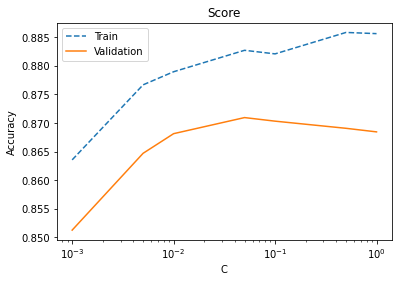

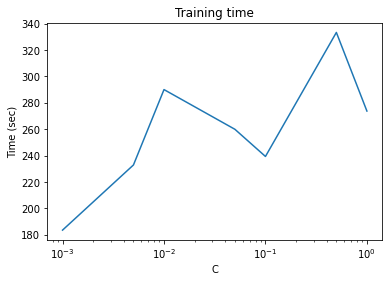

In [131]:
plot_grid_search(results, 'C', None, 'log')

In [ ]:
evaluate_model('My Linear SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

Training on the original train set with params = {'C': 0.05}


#### 3.5 Linear SVM - small

Ακολουθεί παρόμοια βελτιστοποίηση του sklearn.svm.SVC με linear kernel στο μικρό train set με linear kernel.

In [ ]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = svm.SVC(kernel='linear')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small, verbose=2)

In [ ]:
plot_grid_search(results, 'C', None, 'log')

In [ ]:
evaluate_model('Linear SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.6 Linear SVM

Ακολουθεί παρόμοια βελτιστοποίηση του sklearn.svm.SVC με linear kernel σε ολόκληρο το train set.

In [17]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = svm.SVC(kernel='linear')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

[1/7] {'C': 0.001}: train_acc = 0.8763, val_acc = 0.8762 | t = 65 sec = 1.1 min
[2/7] {'C': 0.005}: train_acc = 0.8822, val_acc = 0.8820 | t = 57 sec = 1.0 min
[3/7] {'C': 0.01}: train_acc = 0.8830, val_acc = 0.8829 | t = 56 sec = 0.9 min
[4/7] {'C': 0.05}: train_acc = 0.8830, val_acc = 0.8830 | t = 64 sec = 1.1 min
[5/7] {'C': 0.1}: train_acc = 0.8831, val_acc = 0.8830 | t = 86 sec = 1.4 min
[6/7] {'C': 0.5}: train_acc = 0.8831, val_acc = 0.8832 | t = 234 sec = 3.9 min
[7/7] {'C': 1.0}: train_acc = 0.8831, val_acc = 0.8831 | t = 417 sec = 7.0 min

Best params = {'C': 0.5}
Maximum validation accuracy = 0.88325



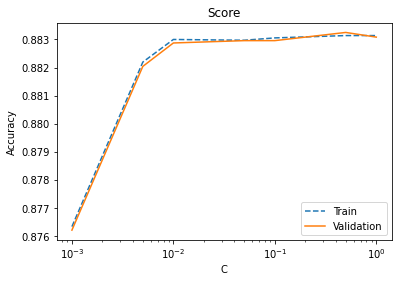

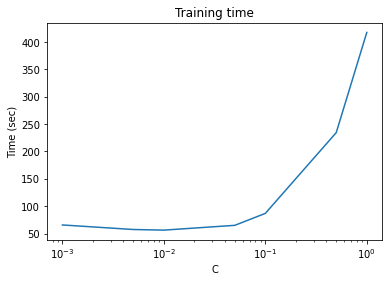

In [18]:
plot_grid_search(results, 'C', None, 'log')

Training on the original train set with params = {'C': 0.5}
Training time = 866 sec = 14.4 min
Train accuracy = 0.8836
Test accuracy = 0.8872


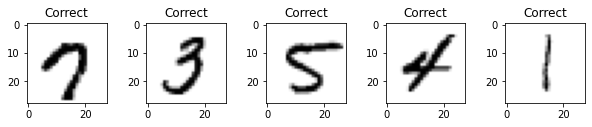

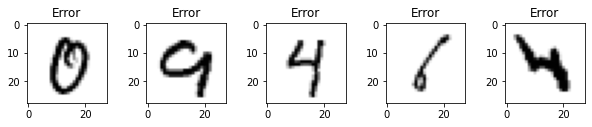

In [19]:
evaluate_model('Linear SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.7 My Polynomial SVM - small

Ακολουθεί βελτιστοποίηση του MySVM με polynomial kernel στο μικρο train set ως προς τις παραμέτρους C και degree. Το degree είναι ο βαθμός του πολυωνύμου. Το gamma έχει την default τιμή 'scale' και υπολογίζεται ως gamma = 1/(n_features*X.var()).

Kernel: $ K(\mathbf{x}, \mathbf{x}') = (\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r)^d $

In [117]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = MySVM(kernel='poly')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small, verbose=2)

Support vectors:  0
[1/28] {'C': 0.001, 'degree': 2}: train_acc = 0.5013, val_acc = 0.5410 | t = 76.71 sec = 1.3 min
Support vectors:  0
[2/28] {'C': 0.001, 'degree': 3}: train_acc = 0.5013, val_acc = 0.5410 | t = 96.92 sec = 1.6 min
Support vectors:  0
[3/28] {'C': 0.001, 'degree': 4}: train_acc = 0.5013, val_acc = 0.5410 | t = 80.96 sec = 1.3 min
Support vectors:  0
[4/28] {'C': 0.001, 'degree': 5}: train_acc = 0.5013, val_acc = 0.5410 | t = 75.64 sec = 1.3 min
Support vectors:  0
[5/28] {'C': 0.01, 'degree': 2}: train_acc = 0.5013, val_acc = 0.5410 | t = 58.40 sec = 1.0 min
Support vectors:  0
[6/28] {'C': 0.01, 'degree': 3}: train_acc = 0.5013, val_acc = 0.5410 | t = 56.89 sec = 0.9 min
Support vectors:  0
[7/28] {'C': 0.01, 'degree': 4}: train_acc = 0.5013, val_acc = 0.5410 | t = 63.39 sec = 1.1 min
Support vectors:  0
[8/28] {'C': 0.01, 'degree': 5}: train_acc = 0.5013, val_acc = 0.5410 | t = 85.81 sec = 1.4 min
Support vectors:  2008
[9/28] {'C': 0.1, 'degree': 2}: train_acc = 0

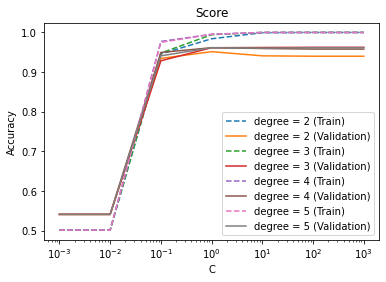

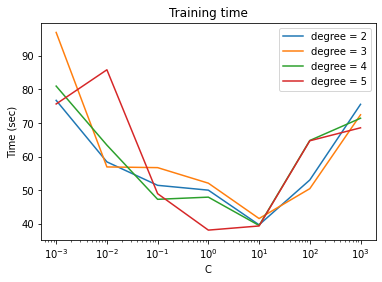

In [118]:
plot_grid_search(results, 'C', 'degree', 'log')

Training on the original train set with params = {'C': 100.0, 'degree': 3}
Support vectors:  1534
Training time = 276.17 sec = 4.6 min
Train accuracy = 1.0
Test accuracy = 0.9727


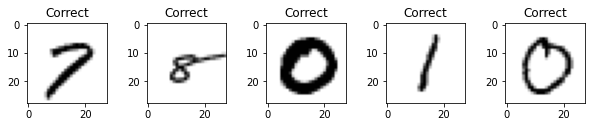

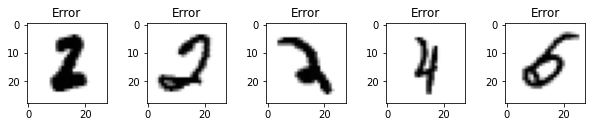

In [119]:
evaluate_model('My Polynomial SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.8 Polynomial SVM - small

Ακολουθεί παρόμοια βελτιστοποίηση του sklearn.svm.SVC με polynomial kernel στο μικρο train set.

In [120]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = svm.SVC(kernel='poly')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small, verbose=2)

[1/28] {'C': 0.001, 'degree': 2}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.24 sec = 0.0 min
[2/28] {'C': 0.001, 'degree': 3}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.27 sec = 0.0 min
[3/28] {'C': 0.001, 'degree': 4}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.62 sec = 0.0 min
[4/28] {'C': 0.001, 'degree': 5}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.17 sec = 0.0 min
[5/28] {'C': 0.01, 'degree': 2}: train_acc = 0.6317, val_acc = 0.6430 | t = 2.21 sec = 0.0 min
[6/28] {'C': 0.01, 'degree': 3}: train_acc = 0.5897, val_acc = 0.6130 | t = 2.07 sec = 0.0 min
[7/28] {'C': 0.01, 'degree': 4}: train_acc = 0.5477, val_acc = 0.5775 | t = 2.10 sec = 0.0 min
[8/28] {'C': 0.01, 'degree': 5}: train_acc = 0.5410, val_acc = 0.5710 | t = 2.11 sec = 0.0 min
[9/28] {'C': 0.1, 'degree': 2}: train_acc = 0.9467, val_acc = 0.9335 | t = 1.43 sec = 0.0 min
[10/28] {'C': 0.1, 'degree': 3}: train_acc = 0.9343, val_acc = 0.9130 | t = 1.53 sec = 0.0 min
[11/28] {'C': 0.1, 'degree': 4}: train_acc = 0.

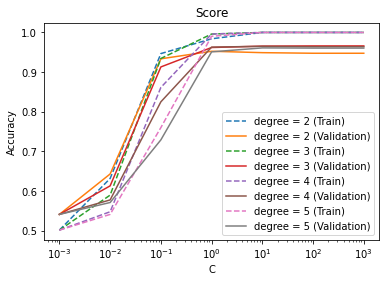

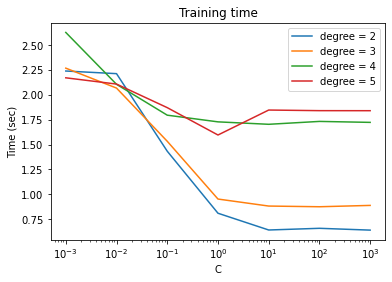

In [121]:
plot_grid_search(results, 'C', 'degree', 'log')

Training on the original train set with params = {'C': 100.0, 'degree': 3}
Training time = 2.75 sec = 0.0 min
Train accuracy = 1.0
Test accuracy = 0.9756


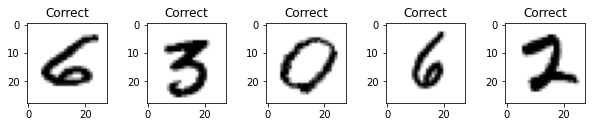

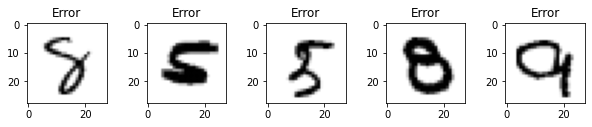

In [122]:
evaluate_model('Polynomial SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.9 Polynomial SVM

Ακολουθεί παρόμοια βελτιστοποίηση του sklearn.svm.SVC με polynomial kernel σε ολόκληρο το train set.

In [25]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = svm.SVC(kernel='poly')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

[1/28] {'C': 0.001, 'degree': 2}: train_acc = 0.6208, val_acc = 0.6214 | t = 159 sec = 2.7 min
[2/28] {'C': 0.001, 'degree': 3}: train_acc = 0.5963, val_acc = 0.5963 | t = 162 sec = 2.7 min
[3/28] {'C': 0.001, 'degree': 4}: train_acc = 0.5508, val_acc = 0.5495 | t = 163 sec = 2.7 min
[4/28] {'C': 0.001, 'degree': 5}: train_acc = 0.5468, val_acc = 0.5464 | t = 160 sec = 2.7 min
[5/28] {'C': 0.01, 'degree': 2}: train_acc = 0.9432, val_acc = 0.9460 | t = 101 sec = 1.7 min
[6/28] {'C': 0.01, 'degree': 3}: train_acc = 0.9302, val_acc = 0.9309 | t = 104 sec = 1.7 min
[7/28] {'C': 0.01, 'degree': 4}: train_acc = 0.8562, val_acc = 0.8521 | t = 127 sec = 2.1 min
[8/28] {'C': 0.01, 'degree': 5}: train_acc = 0.7534, val_acc = 0.7504 | t = 132 sec = 2.2 min
[9/28] {'C': 0.1, 'degree': 2}: train_acc = 0.9706, val_acc = 0.9705 | t = 43 sec = 0.7 min
[10/28] {'C': 0.1, 'degree': 3}: train_acc = 0.9802, val_acc = 0.9758 | t = 47 sec = 0.8 min
[11/28] {'C': 0.1, 'degree': 4}: train_acc = 0.9852, val_ac

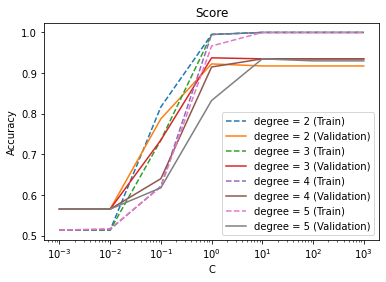

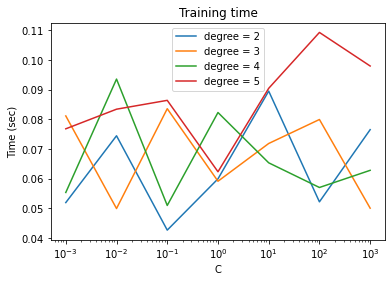

In [29]:
plot_grid_search(results, 'C', 'degree', 'log')

Training on the original train set with params = {'C': 1.0, 'degree': 4}
Training time = 194 sec = 3.2 min
Train accuracy = 0.9971833333333333
Test accuracy = 0.9908


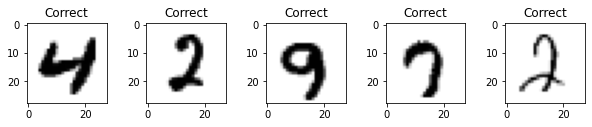

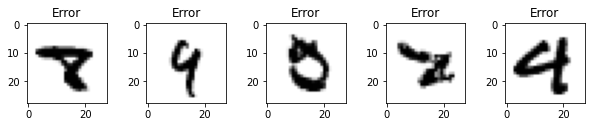

In [27]:
evaluate_model('Polynomial SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.10 My RBF SVM - small

Ακολουθεί βελτιστοποίηση του sklearn.svm.SVC με rbf kernel ως προς τις παραμέτρους C και gamma. Το gamma δείχνει πόσο μακριά φτάνει η επιρροή ενός παραδείγματος.

Kernel: $ K(\mathbf{x}, \mathbf{x}') = e^{-\gamma||\mathbf{x}-\mathbf{x}'||^2} $

In [123]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = MySVM(kernel='rbf')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small, verbose=2)

Support vectors:  0
[1/18] {'C': 0.001, 'gamma': 0.01}: train_acc = 0.5013, val_acc = 0.5410 | t = 66.56 sec = 1.1 min
Support vectors:  0
[2/18] {'C': 0.001, 'gamma': 0.1}: train_acc = 0.5013, val_acc = 0.5410 | t = 57.63 sec = 1.0 min
Support vectors:  0
[3/18] {'C': 0.001, 'gamma': 1.0}: train_acc = 0.5013, val_acc = 0.5410 | t = 40.06 sec = 0.7 min
Support vectors:  0
[4/18] {'C': 0.01, 'gamma': 0.01}: train_acc = 0.5013, val_acc = 0.5410 | t = 43.20 sec = 0.7 min
Support vectors:  0
[5/18] {'C': 0.01, 'gamma': 0.1}: train_acc = 0.5013, val_acc = 0.5410 | t = 61.81 sec = 1.0 min
Support vectors:  0
[6/18] {'C': 0.01, 'gamma': 1.0}: train_acc = 0.5013, val_acc = 0.5410 | t = 50.94 sec = 0.8 min
Support vectors:  1674
[7/18] {'C': 0.1, 'gamma': 0.01}: train_acc = 0.8947, val_acc = 0.8910 | t = 52.44 sec = 0.9 min
Support vectors:  2842
[8/18] {'C': 0.1, 'gamma': 0.1}: train_acc = 0.9723, val_acc = 0.9075 | t = 47.37 sec = 0.8 min
Support vectors:  3000
[9/18] {'C': 0.1, 'gamma': 1.0}

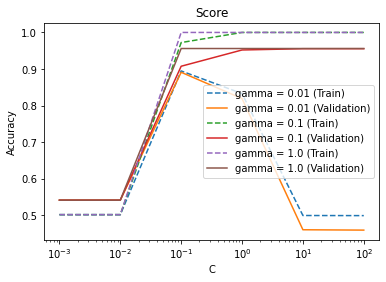

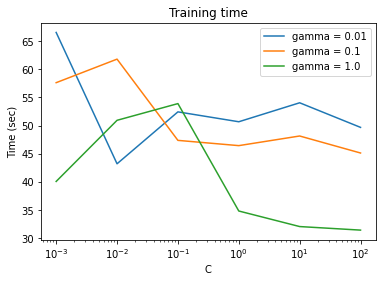

In [124]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original train set with params = {'C': 0.1, 'gamma': 1.0}
Support vectors:  4999
Training time = 171.24 sec = 2.9 min
Train accuracy = 1.0
Test accuracy = 0.97


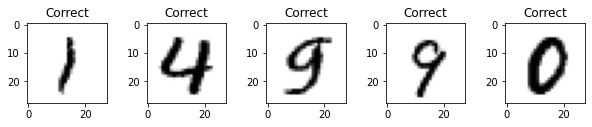

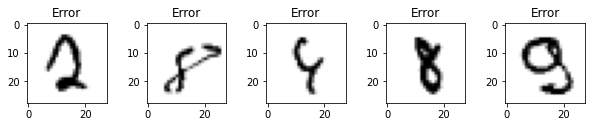

In [125]:
evaluate_model('My RBF SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.11 RBF SVM - small

Ακολουθεί παρόμοια βελτιστοποίηση του sklearn.svm.SVC με rbf kernel στο μικρό το train set.

In [126]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = svm.SVC(kernel='rbf')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small, verbose=2)

[1/18] {'C': 0.001, 'gamma': 0.01}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.67 sec = 0.0 min
[2/18] {'C': 0.001, 'gamma': 0.1}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.50 sec = 0.0 min
[3/18] {'C': 0.001, 'gamma': 1.0}: train_acc = 0.5013, val_acc = 0.5410 | t = 3.97 sec = 0.1 min
[4/18] {'C': 0.01, 'gamma': 0.01}: train_acc = 0.8203, val_acc = 0.8070 | t = 2.61 sec = 0.0 min
[5/18] {'C': 0.01, 'gamma': 0.1}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.69 sec = 0.0 min
[6/18] {'C': 0.01, 'gamma': 1.0}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.57 sec = 0.0 min
[7/18] {'C': 0.1, 'gamma': 0.01}: train_acc = 0.9047, val_acc = 0.8975 | t = 1.50 sec = 0.0 min
[8/18] {'C': 0.1, 'gamma': 0.1}: train_acc = 0.6387, val_acc = 0.5980 | t = 2.80 sec = 0.0 min
[9/18] {'C': 0.1, 'gamma': 1.0}: train_acc = 0.5013, val_acc = 0.5410 | t = 2.59 sec = 0.0 min
[10/18] {'C': 1.0, 'gamma': 0.01}: train_acc = 0.9673, val_acc = 0.9510 | t = 0.93 sec = 0.0 min
[11/18] {'C': 1.0, 'gamma': 0.1}: tr

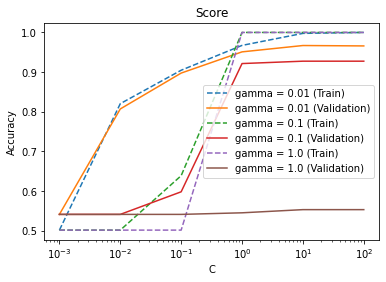

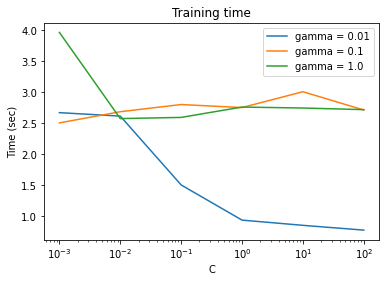

In [127]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original train set with params = {'C': 10.0, 'gamma': 0.01}
Training time = 1.95 sec = 0.0 min
Train accuracy = 0.9972
Test accuracy = 0.9753


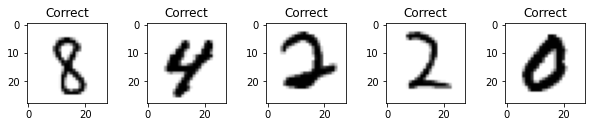

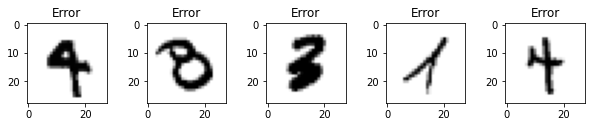

In [128]:
evaluate_model('RBF SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.12 RBF SVM

Ακολουθεί παρόμοια βελτιστοποίηση του sklearn.svm.SVC με rbf kernel σε ολόκληρο το train set.

In [28]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = svm.SVC(kernel='rbf')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

[1/18] {'C': 0.001, 'gamma': 0.01}: train_acc = 0.8232, val_acc = 0.8296 | t = 181 sec = 3.0 min
[2/18] {'C': 0.001, 'gamma': 0.1}: train_acc = 0.5084, val_acc = 0.5085 | t = 187 sec = 3.1 min
[3/18] {'C': 0.001, 'gamma': 1.0}: train_acc = 0.5084, val_acc = 0.5085 | t = 155 sec = 2.6 min
[4/18] {'C': 0.01, 'gamma': 0.01}: train_acc = 0.9068, val_acc = 0.9095 | t = 105 sec = 1.8 min
[5/18] {'C': 0.01, 'gamma': 0.1}: train_acc = 0.6432, val_acc = 0.6434 | t = 175 sec = 2.9 min
[6/18] {'C': 0.01, 'gamma': 1.0}: train_acc = 0.5084, val_acc = 0.5085 | t = 156 sec = 2.6 min
[7/18] {'C': 0.1, 'gamma': 0.01}: train_acc = 0.9624, val_acc = 0.9608 | t = 53 sec = 0.9 min
[8/18] {'C': 0.1, 'gamma': 0.1}: train_acc = 0.9267, val_acc = 0.9099 | t = 163 sec = 2.7 min
[9/18] {'C': 0.1, 'gamma': 1.0}: train_acc = 0.5084, val_acc = 0.5085 | t = 155 sec = 2.6 min
[10/18] {'C': 1.0, 'gamma': 0.01}: train_acc = 0.9841, val_acc = 0.9819 | t = 28 sec = 0.5 min
[11/18] {'C': 1.0, 'gamma': 0.1}: train_acc = 0.

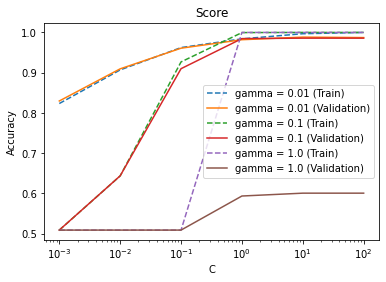

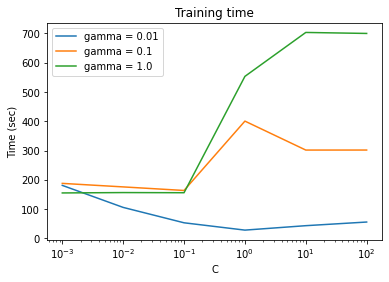

In [29]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original train set with params = {'C': 10.0, 'gamma': 0.01}
Training time = 119 sec = 2.0 min
Train accuracy = 0.9968666666666667
Test accuracy = 0.9905


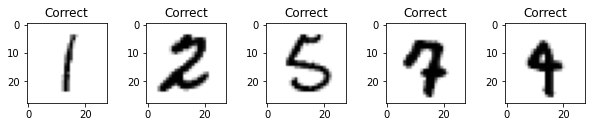

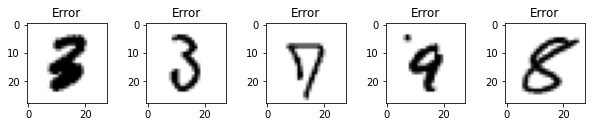

In [30]:
evaluate_model('RBF SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.13 Sigmoid SVM

Ακολουθεί βελτιστοποίηση του svm.SVC με sigmoid kernel ως προς τις παραμέτρους C και gamma.

Kernel: $ K(\mathbf{x}, \mathbf{x}') = tanh(\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r) $

In [31]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.001, 0.01, 0.1)
}

model = svm.SVC(kernel='sigmoid')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

[1/18] {'C': 0.001, 'gamma': 0.001}: train_acc = 0.5084, val_acc = 0.5085 | t = 189 sec = 3.2 min
[2/18] {'C': 0.001, 'gamma': 0.01}: train_acc = 0.7957, val_acc = 0.8003 | t = 172 sec = 2.9 min
[3/18] {'C': 0.001, 'gamma': 0.1}: train_acc = 0.7132, val_acc = 0.7218 | t = 136 sec = 2.3 min
[4/18] {'C': 0.01, 'gamma': 0.001}: train_acc = 0.7972, val_acc = 0.8014 | t = 171 sec = 2.9 min
[5/18] {'C': 0.01, 'gamma': 0.01}: train_acc = 0.8526, val_acc = 0.8555 | t = 109 sec = 1.8 min
[6/18] {'C': 0.01, 'gamma': 0.1}: train_acc = 0.6056, val_acc = 0.6133 | t = 105 sec = 1.8 min
[7/18] {'C': 0.1, 'gamma': 0.001}: train_acc = 0.8581, val_acc = 0.8604 | t = 107 sec = 1.8 min
[8/18] {'C': 0.1, 'gamma': 0.01}: train_acc = 0.8502, val_acc = 0.8543 | t = 79 sec = 1.3 min
[9/18] {'C': 0.1, 'gamma': 0.1}: train_acc = 0.5913, val_acc = 0.5976 | t = 100 sec = 1.7 min
[10/18] {'C': 1.0, 'gamma': 0.001}: train_acc = 0.8761, val_acc = 0.8758 | t = 77 sec = 1.3 min
[11/18] {'C': 1.0, 'gamma': 0.01}: train_

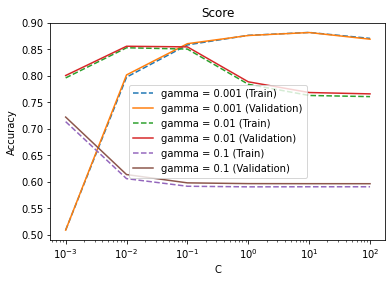

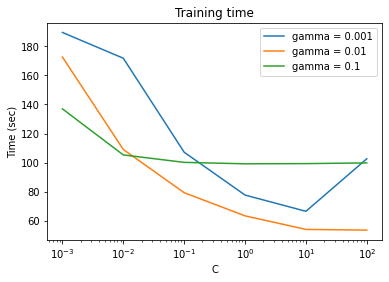

In [32]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original train set with params = {'C': 10.0, 'gamma': 0.001}
Training time = 186 sec = 3.1 min
Train accuracy = 0.8810333333333333
Test accuracy = 0.885


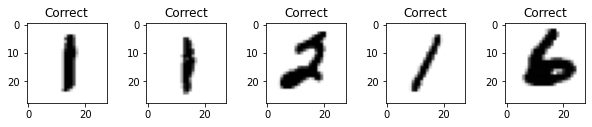

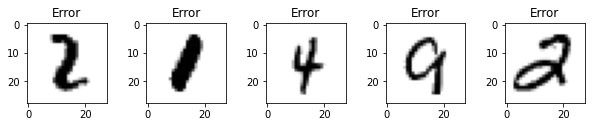

In [33]:
evaluate_model('Sigmoid SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.14 Nearest Neighbors

Ακολουθεί βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier ως προς τις παραμέτρους n_neighbors και p. Στον πολυδιάστατο χώρο των χαρακτηριστικών οι k πλησιέστεροι γείτονες του κάθε δείγματος ψηφίζουν για να αποφασίσουν την κλάση στην οποία ανήκει. Για να βρεθούν οι πλησιέστεροι γείτονες χρησιμοποιείται η απόσταση minkowski:

$d_p(\mathbf{x}, \mathbf{y}) = \sqrt[p]{\sum_{i}(x_i-y_i)^p}$

In [ ]:
from sklearn import neighbors

param_dict = {
    'n_neighbors': (1, 2, 5, 10, 20),
    'p': (1, 2, 3)
}

model = neighbors.KNeighborsClassifier()
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

[1/21] {'n_neighbors': 1, 'p': 1}: train_acc = 1.0000, val_acc = 0.9822 | t = 0 sec = 0.0 min
[2/21] {'n_neighbors': 1, 'p': 2}: train_acc = 1.0000, val_acc = 0.9846 | t = 0 sec = 0.0 min
[3/21] {'n_neighbors': 1, 'p': 3}: train_acc = 1.0000, val_acc = 0.9843 | t = 0 sec = 0.0 min
[4/21] {'n_neighbors': 2, 'p': 1}: train_acc = 0.9934, val_acc = 0.9819 | t = 0 sec = 0.0 min
[5/21] {'n_neighbors': 2, 'p': 2}: train_acc = 0.9936, val_acc = 0.9824 | t = 0 sec = 0.0 min
[6/21] {'n_neighbors': 2, 'p': 3}: train_acc = 0.9932, val_acc = 0.9834 | t = 0 sec = 0.0 min
[7/21] {'n_neighbors': 3, 'p': 1}: train_acc = 0.9911, val_acc = 0.9832 | t = 0 sec = 0.0 min
[8/21] {'n_neighbors': 3, 'p': 2}: train_acc = 0.9919, val_acc = 0.9851 | t = 0 sec = 0.0 min
[9/21] {'n_neighbors': 3, 'p': 3}: train_acc = 0.9916, val_acc = 0.9854 | t = 0 sec = 0.0 min
[10/21] {'n_neighbors': 4, 'p': 1}: train_acc = 0.9901, val_acc = 0.9825 | t = 0 sec = 0.0 min
[11/21] {'n_neighbors': 4, 'p': 2}: train_acc = 0.9913, val

In [ ]:
plot_grid_search(results, 'n_neighbors', 'p')

In [ ]:
evaluate_model('Nearest Neighbors', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.15 Nearest Class Centroid

Ακολουθεί βελτιστοποίση του sklearn.neighbors.NearestCentroid ως προς το shrink_threshold. Κάθε κλάση αντιπροσωπεύεται απο το centroid των μελών της.

In [ ]:
param_dict = {
    'shrink_threshold': np.arange(0, 1.1, 0.1)
}

model = neighbors.NearestCentroid()
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=2)

In [ ]:
plot_grid_search(results, 'shrink_threshold')

In [ ]:
evaluate_model('Nearest Class Centroid', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

### 4. Σύνοψη αποτελεσμάτων

In [ ]:
final_results_df = pd.DataFrame(final_results)
final_results_df = final_results_df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
final_results_df.set_properties(**{'text-align': 'left'}).hide_index()